In [1]:
import time
start = time.time()

import numpy as np
import scipy.io
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
#%matplotlib inline
import torch
import torch.nn as nn
import torch.utils.data
from torch.autograd import Variable

In [2]:
mat = scipy.io.loadmat('Train_Raw_C.mat')
Train_Raw = mat['Train_Raw']
mat1 = scipy.io.loadmat('Val_Raw_C.mat')
Val_Raw = mat1['Val_Raw']

In [3]:
l,w = 45,35
Total_Train_Photo = int((Train_Raw.shape[0]*Train_Raw.shape[1])/(l*w))
Total_Val_Photo = int((Val_Raw.shape[0]*Val_Raw.shape[1])/(l*w))
Photo_Train_Col = 19
Photo_Val_Col = 18
print(Total_Train_Photo)
print(Total_Val_Photo)

2850
2700


In [4]:
#Normalisasi
Train_Raw_Norm = Train_Raw/255
Val_Raw_Norm = Val_Raw/255

In [5]:
i=0
input_data_raw = np.zeros([Total_Train_Photo,l,w])
val_data_raw = np.zeros([Total_Val_Photo,l,w])
for a in range(0,int(Total_Train_Photo/Photo_Train_Col)):
    for b in range(0,Photo_Train_Col):
        input_data_raw[i,:,:] = Train_Raw_Norm[45*a:45+45*a,35*b:35+35*b]
        i=i+1
i,a,b=0,0,0
for a in range(0,int(Total_Val_Photo/Photo_Val_Col)):
    for b in range(0,Photo_Val_Col):
        val_data_raw[i,:,:] = Val_Raw_Norm[45*a:45+45*a,35*b:35+35*b]
        i=i+1
        
print(input_data_raw.shape)
print(val_data_raw.shape)

(2850, 45, 35)
(2700, 45, 35)


In [7]:
#plt.imshow(input_data_raw[2849,:,:], cmap='gray', vmin=0, vmax=1)

In [6]:
tar = np.eye(10)
target_train = np.zeros([Total_Train_Photo,10])
target_val = np.zeros([Total_Val_Photo,10])
for d in range(0,10):    
    target_train[0+int(Total_Train_Photo/10)*d:int(Total_Train_Photo/10)+int(Total_Train_Photo/10)*d,:] = tar[d,:]
d=0
for d in range(0,10):
    target_val[0+int(Total_Val_Photo/10)*d:int(Total_Val_Photo/10)+int(Total_Val_Photo/10)*d,:] = tar[d,:]
print(target_train.shape)
print(target_val.shape)

(2850, 10)
(2700, 10)


In [7]:
tebal_train, tebal_val = Total_Train_Photo, Total_Val_Photo
target_train3d = np.zeros(shape=(tebal_train, 1, 10))
target_val3d = np.zeros(shape=(tebal_val, 1, 10))
i=0

for i in range(tebal_train):
    target_train3d[i,0,:] = target_train[i,:]
for i in range(tebal_val):
    target_val3d[i,0,:] = target_val[i,:]

In [8]:
def train_in4d(data):
    image_size = [45,35]
    data4d = np.zeros([Total_Train_Photo,1,image_size[0],image_size[1]])
    data4d[:,0,:,:] = data
    return data4d

def val_inl4d(data):
    image_size = [45,35]
    data4d = np.zeros([Total_Val_Photo,1,image_size[0],image_size[1]])
    data4d[:,0,:,:] = data
    return data4d

def train_tar4d(data):
    image_size = [1,10]
    data4d = np.zeros([Total_Train_Photo,1,image_size[0],image_size[1]])
    data4d[:,0,:,:] = data
    return data4d

def val_tarl4d(data):
    image_size = [1,10]
    data4d = np.zeros([Total_Val_Photo,1,image_size[0],image_size[1]])
    data4d[:,0,:,:] = data
    return data4d

In [9]:
input_train4d = train_in4d(input_data_raw)
input_val4d = val_inl4d(val_data_raw)

target_train4d = train_tar4d(target_train3d)
target_val4d = val_tarl4d(target_val3d)

print(input_train4d.shape)
print(input_val4d.shape)
print(target_train4d.shape)
print(target_val4d.shape)

(2850, 1, 45, 35)
(2700, 1, 45, 35)
(2850, 1, 1, 10)
(2700, 1, 1, 10)


In [11]:
device = torch.device('cuda:0')

epoch_max = 12000
learning_rate = 0.2
batch_size_train = int(Total_Train_Photo/10)
batch_size_val = int(Total_Val_Photo/10)

In [12]:
input_train4d = torch.from_numpy(input_train4d).float().cuda()
target_train4d = torch.from_numpy(target_train4d).float().cuda()
input_val4d = torch.from_numpy(input_val4d).float().cuda()
target_val4d = torch.from_numpy(target_val4d).float().cuda()

target_train = torch.from_numpy(target_train).float().cuda()
target_val = torch.from_numpy(target_val).float().cuda()

dataset_train = torch.utils.data.TensorDataset(input_train4d, target_train)
dataset_val = torch.utils.data.TensorDataset(input_val4d, target_val)

kwargs = {}
train_loader = torch.utils.data.DataLoader(dataset_train,
                                           batch_size=batch_size_train, 
                                           shuffle=True,**kwargs)
val_loader = torch.utils.data.DataLoader(dataset_val,
                                         batch_size=batch_size_val, 
                                         shuffle=True,**kwargs)

print('There are {} images in the training set'.format(len(dataset_train)))
print('There are {} images in the test set'.format(len(dataset_val)))
print('There are {} batches in the train loader'.format(len(train_loader)))
print('There are {} batches in the testloader'.format(len(val_loader)))

There are 2850 images in the training set
There are 2700 images in the test set
There are 10 batches in the train loader
There are 10 batches in the testloader


In [13]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 20, kernel_size=5, stride=1, padding=0),
#             nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=1))
        self.layer2 = nn.Sequential(
            nn.Conv2d(20, 40, kernel_size=5, stride=1, padding=0),
#             nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=1))
        self.fc1 = nn.Linear(32 * 22 * 40, 1000)
#         self.drop_out = nn.Dropout()
        self.act1 = nn.Tanh()
    
        self.fc2 = nn.Linear(1000, 500)
        self.act2 = nn.Tanh()
        
        self.fc3 = nn.Linear(500,10)
        self.act3 = nn.Sigmoid()
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
#         out = self.drop_out(out)
        out = out.view(-1, 32 * 22 * 40)
        out = self.act1(self.fc1(out))
#         out = self.fc1(out)
        out = self.act2(self.fc2(out))
        out = self.act3(self.fc3(out))
#         out = self.fc3(out)
        return out

In [14]:
model = ConvNet()
model = model.cuda()    
loss_fn = torch.nn.MSELoss(size_average='false').cuda()        
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.3)
print(model)
for p in model.parameters():
    print(p.size())

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=4, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(20, 40, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=28160, out_features=1000, bias=True)
  (act1): Tanh()
  (fc2): Linear(in_features=1000, out_features=500, bias=True)
  (act2): Tanh()
  (fc3): Linear(in_features=500, out_features=10, bias=True)
  (act3): Sigmoid()
)
torch.Size([20, 1, 5, 5])
torch.Size([20])
torch.Size([40, 20, 5, 5])
torch.Size([40])
torch.Size([1000, 28160])
torch.Size([1000])
torch.Size([500, 1000])
torch.Size([500])
torch.Size([10, 500])
torch.Size([10])


c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\torch\nn\_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [15]:
#Training dan Validasi CNN
train_loss = []
val_loss = []
train_accuracy = []
val_accuracy = []
#Train

for epoch in range(epoch_max):
    benar = 0
    salah = 0
    iter_loss = 0.0
    iterations = 0
    model.train()
    
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = Variable(inputs)
        labels = Variable(labels)
        inputs = inputs.cuda()
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        iter_loss = iter_loss+loss.item()
        loss.backward()
        optimizer.step()
        outputs_recog = torch.round(outputs)
        labels_recog = torch.round(labels)
        for hitung in range(batch_size_train):
            if torch.equal(outputs_recog[hitung,:], labels_recog[hitung,:]):
                benar = benar + 1
            else:
                salah = salah + 1
        iterations = iterations + 1
                    
    recognition_rate = (benar/Total_Train_Photo)*100
    train_accuracy.append(recognition_rate)
    train_loss.append(iter_loss)
    
    if (epoch+1)%1000 == 0:
        torch.save(model.state_dict(),'CNN_3DFaceRecog_Save_5050_Col_v8_6layer.pth')
    
#Validasi    
    if (epoch+1)%100 == 0:
        loss_iter_val = 0.0
        benar_val = 0
        salah_val = 0
        iterations = 0

        model.eval()

        for i, (inputs, labels) in enumerate(val_loader):
            inputs = Variable(inputs)
            labels = Variable(labels)
            inputs = inputs.cuda()
            labels = labels.cuda()
            outputs = model(inputs)
            loss_v = loss_fn(outputs, labels)
            loss_iter_val = loss_iter_val+loss_v.item()
            outputs_recog = torch.round(outputs)
            labels_recog = torch.round(labels)
            for hitung in range(batch_size_val):
                if torch.equal(outputs_recog[hitung,:], labels_recog[hitung,:]):
                    benar_val = benar_val + 1
                else:
                    salah_val = salah_val + 1
            iterations = iterations + 1

        recognition_rate_v = (benar_val/Total_Val_Photo)*100
        val_accuracy.append(recognition_rate_v)
        val_loss.append(loss_iter_val)
    
    print ('Epoch {}/{}, Training Loss: {:.7f}, Training Acc: {:.3f}'.
           format(epoch+1, epoch_max, 
                  train_loss[-1], 
                  train_accuracy[-1])); 
    if (epoch+1)%100 == 0:
        print('\nValidation || Validation Loss: {:.7f}, Validation Acc: {:.3f}\n'
              .format(val_loss[-1],
                     val_accuracy[-1]))

Epoch 1/12, Training Loss: 1.3881382, Training Acc: 0.000
Epoch 2/12, Training Loss: 0.9027035, Training Acc: 0.000
Epoch 3/12, Training Loss: 0.8985813, Training Acc: 0.000
Epoch 4/12, Training Loss: 0.8951296, Training Acc: 0.000
Epoch 5/12, Training Loss: 0.8916807, Training Acc: 0.000
Epoch 6/12, Training Loss: 0.8878553, Training Acc: 0.000
Epoch 7/12, Training Loss: 0.8834653, Training Acc: 0.000
Epoch 8/12, Training Loss: 0.8786623, Training Acc: 0.000
Epoch 9/12, Training Loss: 0.8731781, Training Acc: 0.000
Epoch 10/12, Training Loss: 0.8675051, Training Acc: 0.000
Epoch 11/12, Training Loss: 0.8613567, Training Acc: 0.211
Epoch 12/12, Training Loss: 0.8558326, Training Acc: 1.053


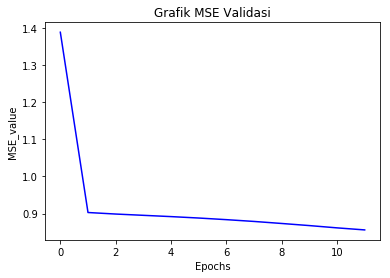

Last epoch validation loss: 0.8558326363563538


In [17]:
plt.plot(train_loss, 'b') # 'r' is the color red
plt.xlabel('Epochs')
plt.ylabel('Loss_value')
plt.title('Loss Graph Training')
plt.show()
print('Last epoch training loss: {}' .format(train_loss[-1]))

In [17]:
torch.save(model.state_dict(),'CNN_3DFaceRecog_Save_5050_Col_v8_6layer.pth')

In [18]:
print('CNN_3DFaceRecognition_v8_5050_Col_TV_6layer')
print('Epochs: {}, Training Loss: {:.7f}, Training Acc: {:.3f}, Validation Loss: {:.7f}, Validation Acc: {:.3f}'
           .format(epoch+1,
                   train_loss[-1],
                   train_accuracy[-1],
                   val_loss[-1],
                   val_accuracy[-1]))
end = time.time()

elapsed = end - start
print('Elapased Time: ', time.strftime("%H:%M:%S", time.gmtime(elapsed)))

CNN_3DFaceRecognition_v7_5050_Col_TV


IndexError: list index out of range

In [19]:
scipy.io.savemat('Epochs_time_loss_5050C_v8.mat', {'Epochs':epoch, 'time':elapsed, 'train_loss':train_loss, 'train_accuracy':train_accuracy})